In [1]:
import re
import numpy as np
import csv
import gzip
import dateutil
import matplotlib.pyplot as plt

In [2]:
Z_FILE = 'primary_table.csv'
HST_FILE = 'hsc/hst_search.csv.gz'
SPITZ_FILE = 'sha/sha_results_table_combined.csv'
SWIFT_FILE = 'swift_table.csv'

In [3]:
# check if a grb has been observed nmonths after burst
def date_checker(grb, obs_time, nmonths=6):
    # grb string, e.g. 040924
    grb_num = re.sub('[^0-9]', '', grb)
    if grb.startswith('9'):
        grb_date_str = '19{}'.format(grb_num)
    else:
        grb_date_str = '20{}'.format(grb_num)
    
    grb_date = dateutil.parser.parse(grb_date_str)
    obs_date = dateutil.parser.parse(obs_time)
    relative = dateutil.relativedelta.relativedelta(months=nmonths)
    
    return obs_date > grb_date + relative

In [4]:
# grbs with redshift
z_grbs = set()
with open(Z_FILE, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        try:
            z = float(row['z'])
        # only accept "valid" redshifts
        except ValueError:
            continue
        z_grbs.add(row['grb'])

In [5]:
# grbs observed in Spitzer
spitz_grbs = set()
with open(SPITZ_FILE, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        grb = row['Search_Tgt'][3:]
        obs_date = row['reqendtime']
        
        is_late_enough = date_checker(grb, obs_date, nmonths=3)       
        if is_late_enough:
            spitz_grbs.add(grb)

In [6]:
# grbs observed in HST
hst_grbs = set()
# hsc results indexed by primary_table since queries are 
# made from primary_table (parsed)
query_table = 'hsc/sha_hsc_query_table.csv'
with open(query_table, 'r') as f:
    grb_list = f.readlines()

with gzip.open(HST_FILE, 'rt') as f:
    reader = csv.DictReader(f)
    next(reader)     # skip dtype header
    for row in reader:
        entry = int(row['Entry']) - 1
        grb = grb_list[entry].split(',')[-1][3:].strip('\n')
        if grb in hst_grbs:
            continue
        obs_date = row['Stop Time']

        is_grb_target = (
            (
                'grb' in row['Target Name'].lower() or
                'gamma' in row['Target Descrip'].lower()
            )
        )
        is_near = float(row["Ang Sep (')"]) < 5.2    # dist in arcmin   
        if (is_grb_target or is_near):
            hst_grbs.add(grb)

In [7]:
print(len(hst_grbs), len(spitz_grbs), len(z_grbs))

236 612 449


In [10]:
SAMPLE_GRBS = (z_grbs.intersection(spitz_grbs).intersection(hst_grbs))
print(len(SAMPLE_GRBS))

125


(0.38876889848812096, 3.5696579077838377)

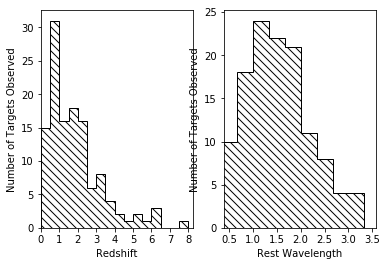

In [9]:
# plotter goes here
# very crude!
z_grbs_dict = {}
with open(Z_FILE, 'r') as f:
    for line in f:
        grb, radec, tel, z = line.split(',')
        try:
            z = float(z)
            z_grbs_dict[grb] = z
        except:
            continue

sample_grbs = z_grbs.intersection(spitz_grbs).intersection(hst_grbs)
z_list = [z_grbs_dict[grb] for grb in sample_grbs]

plt.subplot(1,2,1)
bins = np.arange(2*max(z_list))/2.
ticks = np.arange(max(z_list))
plt.hist(z_list, bins=bins, histtype='step', hatch='\\\\\\', facecolor='w', edgecolor='k')
plt.xlabel('Redshift')
plt.ylabel('Number of Targets Observed')
plt.xticks(ticks)
plt.xlim((0, max(z_list)))

plt.subplot(1,2,2)
wav_list = [3.6/(z_grbs_dict[grb]+1) for grb in sample_grbs]
bins = np.arange(3*(max(wav_list)))/3.
ticks = np.arange(2*max(z_list))/2.
plt.hist(wav_list, bins=bins, histtype='step', hatch='\\\\\\', facecolor='w', edgecolor='k')
plt.xlabel('Rest Wavelength')
plt.ylabel('Number of Targets Observed')
plt.xticks(ticks)
plt.xlim((min(wav_list), max(wav_list)))

In [22]:
BLANCHARD_GRBS = [
    '040924', '041006',
    '050315', '050401', '050525', '050730', '050824', '050908', '051016B', '051022',
    '060124', '060206', '060218', '060512', '060526', '060607', '060614', '060719', '060729', '061007', '061110B',
    '070208', '070306', '070318', '070721B', '070802', '071112C',
    '080319B', '080325', '080430', '080603B', '080707', '080805', '080928', '081007', '081008',' 081109', '081121',
    '090407', '090417B', '090424', '091127', '091208B', 
    '100615A', '100621A',
    '110731A',
    '120119A'
]

In [30]:
missing_grbs = []
for grb in SAMPLE_GRBS:
    if ('X' in grb) or (grb in BLANCHARD_GRBS):
        continue
    else:
        missing_grbs.append(grb)
print(len(missing_grbs))

77


In [31]:
sorted(missing_grbs)

['000131',
 '000301C',
 '000418',
 '000926',
 '010222',
 '010921',
 '011121',
 '011211',
 '020124',
 '020405',
 '020813',
 '021004',
 '021211',
 '030323',
 '030329',
 '050408',
 '050820',
 '050904',
 '060115',
 '060223',
 '060502',
 '060505',
 '060522',
 '060605',
 '060814',
 '060912',
 '060927',
 '061110',
 '061222',
 '070521',
 '071010',
 '071020',
 '071021',
 '071031',
 '071122',
 '080207',
 '080310',
 '080520',
 '080603',
 '080605',
 '080607',
 '080710',
 '080916',
 '081109',
 '081221',
 '090102',
 '090113',
 '090418',
 '090423',
 '090618',
 '100728B',
 '100905A',
 '101225A',
 '111005A',
 '111209A',
 '120521C',
 '120711A',
 '130427A',
 '130505A',
 '130606A',
 '130925A',
 '140515A',
 '150314A',
 '161219B',
 '970228',
 '970508',
 '970828',
 '971214',
 '980425',
 '980613',
 '980703',
 '990123',
 '990506',
 '990510',
 '990705',
 '990712',
 '991208']